# Nuclie Semantic Segmentation - UNet using Tensorflow 2

# Intro
- Dataset used is from Kaggle's Data Science Bowl 2018 - Nuclei Segmentation
- The architecture used is [U-Net](https://arxiv.org/abs/1505.04597), which is very common for image segmentation problems such as this.
- This notebook is inspired from the great kernel [Keras U-net starter - LB 0.277](https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277) by Kjetil Åmdal-Sævik.

In [1]:
import os
import sys
import random
import warnings
from os.path import isfile, join

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from PIL import ImageFile
import cv2

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = '../train/'
TEST_PATH = '../test/'
FINAL_TEST_PATH = '../test_final/'

#TRAIN_PATH = 'data/stage1_train/'
#TEST_PATH = 'data/stage1_test/'
#FINAL_TEST_PATH = 'data/stage2_test_final/'

dir_path = ''

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed
print(tf.__version__)

2.3.1


In [2]:
os.getcwd()

'/Users/fight/Documents/Malaria/malatec/Notebooks'

In [3]:
def get_paths(PATH):
    '''Get train and test path'''
    list_paths_img = []
    list_paths_masks = []
    for root, dirs, files in os.walk(PATH):
        for file in files:
            filename, file_extension = os.path.splitext(file)
            if isfile(join(root, file)) and file_extension == ".png" and not filename.startswith("._") and not 'mask' in filename:
                    list_paths_img.append(join(root,file))
                    new_root = root[:-3] + 'mask'
                    new_file = 'slice_mask' + file[5:]
                    list_paths_masks.append(join(new_root,new_file))

    return list_paths_img, list_paths_masks


In [4]:
train_paths_img, train_paths_mask = get_paths(TRAIN_PATH)
test_paths_img, test_paths_mask = get_paths(TEST_PATH)
final_test_paths_img, final_test_paths_mask = get_paths(FINAL_TEST_PATH)
# train_paths_mask = get_paths(TRAIN_PATH, 'mask')
# test_paths_mask = get_paths(TEST_PATH, 'mask')
# final_test_paths_ = get_paths(FINAL_TEST_PATH, 'mask')

# Get the data
- Downsample both the training and test images to reduce computations
- Retain record of the original sizes of the test images to upsample predicted masks and create correct run-length encodings 

In [81]:
# Get and resize train images and masks
img_train = np.zeros((len(train_paths_img), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
mask_train = np.zeros((len(train_paths_mask), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')

Getting and resizing train images and masks ... 


In [82]:
# Get and resize test images
img_test = np.zeros((len(test_paths_img), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
mask_test = np.zeros((len(test_paths_mask), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()

Getting and resizing test images ... 


In [83]:

def get_img_arrays(train_paths):
    sys.stdout.flush()
    for n, img_path in tqdm(enumerate(train_paths), total=len(train_paths)):
        if not 'mask' in img_path and not 'test' in img_path:
            #Read image files iteratively
            img = imread(img_path)
            img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
            
            #Append image to numpy array for train dataset
            img_train[n] = img

        elif 'mask' in img_path and not 'test' in img_path:
            #Read image files iteratively
            mask = imread(img_path)
            mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
            mask = mask.reshape((IMG_HEIGHT, IMG_WIDTH, 1))
            #Append image to numpy array for train dataset
            mask_train[n] = mask

        elif 'test' in img_path and not 'mask' in img_path:
            #Read image files iteratively
            test = imread(img_path)
            sizes_test.append([test.shape[0], test.shape[1]])
            test = resize(test, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

            #Append image to numpy array for train dataset
            img_test[n] = test

        elif 'test' in img_path and 'mask' in img_path:
            mask = imread(img_path)
            mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
            mask = mask.reshape((IMG_HEIGHT, IMG_WIDTH, 1))
            #Append image to numpy array for train dataset
            mask_test[n] = mask

        else:
            print('SHIIIIT!!!! ', img_path, n)


get_img_arrays(train_paths_mask)
get_img_arrays(train_paths_img)
get_img_arrays(test_paths_img)
get_img_arrays(test_paths_mask)


100%|██████████| 226/226 [00:00<00:00, 331.15it/s]


In [93]:
mask_test[-1]

array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])

## Visualize imported data

2127


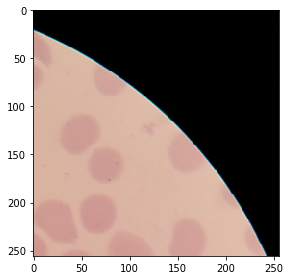

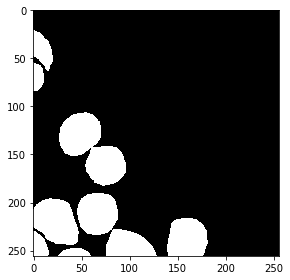

In [8]:
# Check if training data looks all right
ix = random.randint(0, len(img_train))
print(ix)
imshow(img_train[ix])
plt.show()
imshow(np.squeeze(mask_train[ix]))
plt.show()

# Build and train our neural network
Next we build our U-Net model, loosely based on [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) and very similar to [this repo](https://github.com/jocicmarko/ultrasound-nerve-segmentation) from the Kaggle Ultrasound Nerve Segmentation competition.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [30]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = BatchNormalization()(c1)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = BatchNormalization()(c2)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = BatchNormalization()(c3)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = BatchNormalization()(c4)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = BatchNormalization()(c5)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
c5 = BatchNormalization()(c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = BatchNormalization()(c6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)
c6 = BatchNormalization()(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = BatchNormalization()(c7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)
c7 = BatchNormalization()(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = BatchNormalization()(c8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)
c8 = BatchNormalization()(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = BatchNormalization()(c9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)
c9 = BatchNormalization()(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)


In [31]:
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 32) 896         lambda_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 256, 256, 32) 128         conv2d_19[0][0]                  
_______________________________________________________________________________________

In [32]:
# Fit model
earlystopper = EarlyStopping(patience=15, verbose=1)
checkpointer = ModelCheckpoint('model_unet_checkpoint.h5', verbose=1, save_best_only=True)
results = model.fit(img_train, mask_train, validation_split=0.1, batch_size=16, epochs=100, 
                    callbacks=[earlystopper, checkpointer])

Epoch 1/100
133/133 [==============================] - ETA: 0s - loss: 0.2926 - accuracy: 0.8956
Epoch 00001: val_loss improved from inf to 1.69920, saving model to model_unet_checkpoint.h5
133/133 [==============================] - 1198s 9s/step - loss: 0.2926 - accuracy: 0.8956 - val_loss: 1.6992 - val_accuracy: 0.7474
Epoch 2/100
133/133 [==============================] - ETA: 0s - loss: 0.2231 - accuracy: 0.9163
Epoch 00002: val_loss improved from 1.69920 to 0.20155, saving model to model_unet_checkpoint.h5
133/133 [==============================] - 1168s 9s/step - loss: 0.2231 - accuracy: 0.9163 - val_loss: 0.2015 - val_accuracy: 0.9191
Epoch 3/100
133/133 [==============================] - ETA: 0s - loss: 0.2039 - accuracy: 0.9218
Epoch 00003: val_loss improved from 0.20155 to 0.16814, saving model to model_unet_checkpoint.h5
133/133 [==============================] - 1216s 9s/step - loss: 0.2039 - accuracy: 0.9218 - val_loss: 0.1681 - val_accuracy: 0.9547
Epoch 4/100
133/133 [==

KeyboardInterrupt: 


# Make predictions

In [71]:
# Predict on train, val and test
model = load_model('model_unet_checkpoint.h5')
preds_train = model.predict(img_train[:int(img_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(img_train[int(img_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(img_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


8/8 [==============================] - 24s 3s/step


In [75]:
# Create list of upsampled test masks
# This is only required when original pictures are larger or smaller
preds_test_upsampled = []
for i in range(len(preds_test_t)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test_t[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

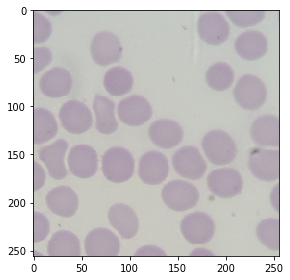

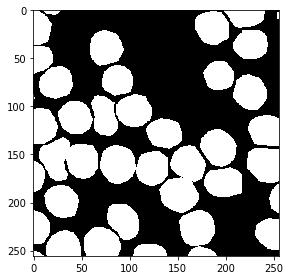

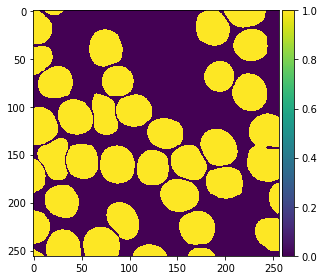

In [76]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_test_t))
imshow(img_train[ix])
plt.show()
imshow(np.squeeze(mask_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

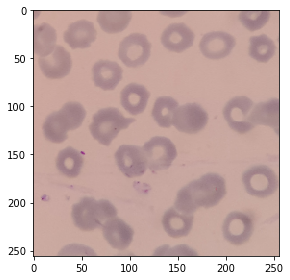

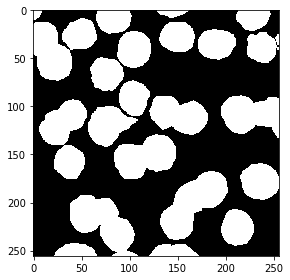

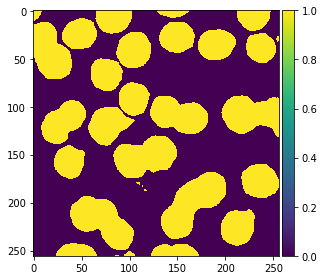

In [74]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(img_train[int(img_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(mask_train[int(mask_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

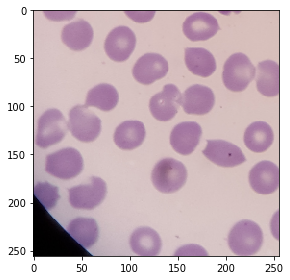

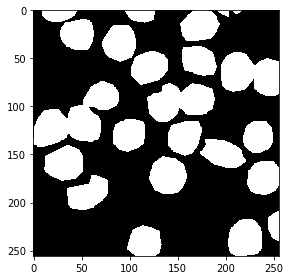

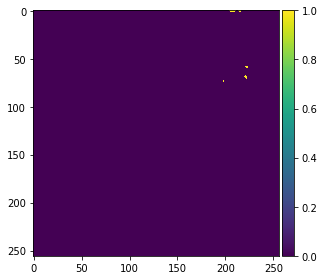

In [99]:
# Perform check on test set
ix = random.randint(0, len(preds_test_t))
imshow(img_test[ix])
plt.show()
imshow(np.squeeze(mask_test[ix]))
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()


# Encode and submit our results

[Link](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python) has an excellent implementation of run-length encoding.



In [ ]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

- Iterate over the test IDs and generate run-length encodings for each seperate mask identified by skimage ...

In [ ]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

- Create submission

In [ ]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-1.csv', index=False)